# Speech Emotion Recognition – Preprocessing
## Notebook 1: Feature Extraction from Audio Files

**Registration Number:** IT24102798  
**Task:** Extract features (MFCC, Chroma, Mel) using GPU acceleration.  
**Objective:** Convert raw audio into numerical feature vectors efficiently with CUDA.


### Step 1: Importing Libraries
First, we need to import the necessary Libraries.

In [1]:
import os
import torch
import torchaudio
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

np.random.seed(42)

Using device: cpu


### Step 2: Emotion Mapping
The RAVDESS dataset encodes emotions as numbers in filenames.  
We map them to human-readable labels.

In [2]:
emotion_map = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

### Step 3: Feature Extraction Function
We extract:  
- **MFCC (40 coefficients)** - timbre, tone quality  
- **Chroma** - pitch class distribution  
- **Mel-Spectrogram** - energy in frequencies  

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mfcc_transform = torchaudio.transforms.MFCC(
    sample_rate=48000,
    n_mfcc=40,
    melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 128}  # bigger FFT for higher quality
).to(device)

mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=48000,
    n_fft=2048,
    hop_length=512,
    n_mels=128
).to(device)

def extract_features(file_path):
    waveform, sr = torchaudio.load(file_path)

    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    if sr != 48000:
        waveform = torchaudio.transforms.Resample(orig_freq=sr, new_freq=48000)(waveform)
        sr = 48000

    waveform = waveform.to(device).squeeze(0)

    mfcc = mfcc_transform(waveform.unsqueeze(0)).squeeze()

    mel = mel_transform(waveform.unsqueeze(0)).squeeze()

    waveform_np = waveform.cpu().numpy()
    chroma = librosa.feature.chroma_stft(
        y=waveform_np,
        sr=sr,
        n_fft=2048,
        hop_length=512
    )
    chroma = torch.tensor(chroma, device=device, dtype=torch.float32)

    return mfcc, mel, chroma

### Step 4: Load Dataset & Extract Features

In [9]:
ravdess_dir = "../data/ravdess"
mfcc_features, mel_features, chroma_features, emotion_labels = [], [], [], []

for root, dirs, files in os.walk(ravdess_dir):
    for file in files:
        if file.endswith(".wav"):
            file_path = os.path.join(root, file)
            emotion_code = file.split("-")[2]
            emotion = emotion_map.get(emotion_code)
            if emotion:
                try:
                    mfcc, mel, chroma = extract_features(file_path)
                    
                    mfcc_features.append(mfcc)
                    mel_features.append(mel)
                    chroma_features.append(chroma)
                    emotion_labels.append(emotion)
                except Exception as e:
                    print("Error in:", file_path, e)

print("Total MFCC Features processed:", len(mfcc_features))
print("Total Mel Features processed:", len(mel_features))
print("Total Chroma Features processed:", len(chroma_features))

Total MFCC Features processed: 2880
Total Mel Features processed: 2880
Total Chroma Features processed: 2880


### Step 5: Feature Padding Function

In [10]:
def pad_feature(extracted_features):
    max_length = max(len(sub_feature) for sub_feature in extracted_features)

    padded_extracted_features = []
    for sub_feature in extracted_features:
        padding_needed = max_length - len(sub_feature)

        sub_feature_np = np.array(sub_feature)

        if padding_needed != 0:
            padded_sub_feature = np.pad(sub_feature_np, (0, padding_needed), 'constant', constant_values=0)
        else:
            padded_sub_feature = sub_feature_np
        
        padded_extracted_features.append(padded_sub_feature)

    return padded_extracted_features

### Step 6: Convert to Arrays

In [2]:
padded_mfcc_features = pad_feature(mfcc_features)
padded_mel_features = pad_feature(mel_features)
padded_chroma_features = pad_feature(chroma_features)

mfcc_array = np.hstack(padded_mfcc_features)
mel_array = np.hstack(padded_mel_features)
chroma_array = np.hstack(padded_chroma_features)

NameError: name 'pad_feature' is not defined

### Step 7: Save Processed Data
Save as `.npy` for fast reloading in later notebooks.

In [1]:
os.makedirs("../results/features_and_labels", exist_ok=True)

np.save("../results/features_and_labels/X_features.npy", X)
np.save("../results/features_and_labels/y_labels.npy", y)

print("Saved X_features.npy and y_labels.npy to ../results/features_and_labels/")

NameError: name 'os' is not defined

### Step 8: Quick EDA
Check class distribution before preprocessing.

C:\Users\MSI\AppData\Local\Temp\ipykernel_26456\3146610740.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, order=pd.Series(y).value_counts().index, palette="muted", legend=False)


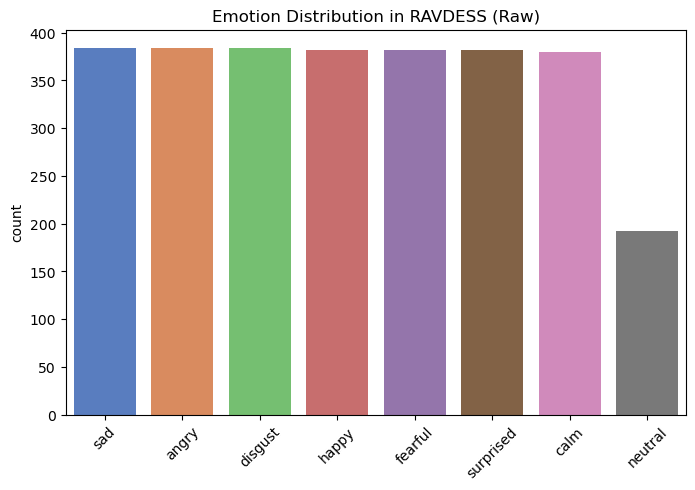

In [27]:
plt.figure(figsize=(8,5))
sns.countplot(x=y, order=pd.Series(y).value_counts().index, palette="muted", legend=False)
plt.title("Emotion Distribution in RAVDESS (Raw)")
plt.xticks(rotation=45)
plt.show()

# ✅ Conclusion
- Used **torchaudio (GPU)** for faster feature extraction.  
- Extracted **MFCC, Mel, and Chroma** features from RAVDESS audio files.  
- Saved into `.npy`.  
- Pipeline is now GPU-ready for future real-time inference.
